In [1]:
import os
import sys
import math
from typing import Final, Tuple
import numpy as np
from scipy.signal import correlate, correlation_lags
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.abspath('..'),os.pardir))
sys.path.append(PROJECT_ROOT)

from electronTransportCode.ProjectUtils import ERE, tuple3d
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.Material import WaterMaterial

%matplotlib widget

In [2]:

SEED: Final[int] = 4
particle = SimplifiedEGSnrcElectron(SEED, '3d')

Ekin = 10/ERE  # 10 MeV particle

def scatterParticle(cost: float, phi: float, vec3d: tuple3d) -> tuple3d:
    """Scatter a particle across polar angle (theta) and azimuthatl scattering angle phi

    Args:
        cost (float): Cosine of polar scattering angle
        phi (float): Azimuthal scattering angle in radians
        vec3d (tuple3d): Direction of travel

    Returns:
        tuple3d: Direction of travel after scattering cost and phi with respect to vec3d
    """
    sint = math.sqrt(1 - cost**2)
    cosphi = math.cos(phi)
    sinphi = math.sin(phi)

    # Rotation matrices (See penelope documentation eq. 1.131)
    if math.isclose(abs(vec3d[2]), 1.0, rel_tol=1e-14):  # indeterminate case
        sign = math.copysign(1.0, vec3d[2])
        x = sign*sint*cosphi
        y = sign*sint*sinphi
        z = sign*cost
    else:
        tempVar = math.sqrt(1-vec3d[2]**2)
        tempVar2 = vec3d[2]*cosphi
        x = vec3d[0]*cost + sint*(vec3d[0]*tempVar2 - vec3d[1]*sinphi)/tempVar
        y = vec3d[1]*cost + sint*(vec3d[1]*tempVar2 + vec3d[0]*sinphi)/tempVar
        z = vec3d[2]*cost - tempVar*sint*cosphi

    # normalized for security
    norm = math.sqrt(x**2 + y**2 + z**2)
    return np.array((x/norm, y/norm, z/norm), dtype=float)

def generatePath(nbCols: int, vec0: tuple3d) -> Tuple[np.ndarray, float]:
    vecs = np.zeros(shape=(3, nbCols), dtype=float)
    vecs[:, 0] = vec0
    muTot = 0.0
    for nbCol in range(nbCols-1):
        mu, phi, _ = particle.sampleScatteringAngles(Ekin, WaterMaterial)
        vecs[:, nbCol+1] = scatterParticle(mu, phi, vecs[:, nbCol])
        muTot += mu
    return vecs, muTot

In [16]:
nbCol = 12000
paths = 5
allvecs = np.empty(shape=(paths, 3, nbCol), dtype=float) 
vec0 = np.array((0.0, 0.0, 1.0), dtype=float)
for path in range(paths):
    vec1, _ = generatePath(nbCol, vec0)
    allvecs[path, :, :] = vec1

corr = np.empty((paths, nbCol), dtype=float)
for path in range(paths):
    for i in range(1, nbCol):
        norm = math.sqrt(allvecs[path, 0, i]**2 + allvecs[path, 1, i]**2 + allvecs[path, 2, i]**2)
        corr[path, i] = allvecs[path, :, 0].dot(allvecs[path, :, i])/(norm)

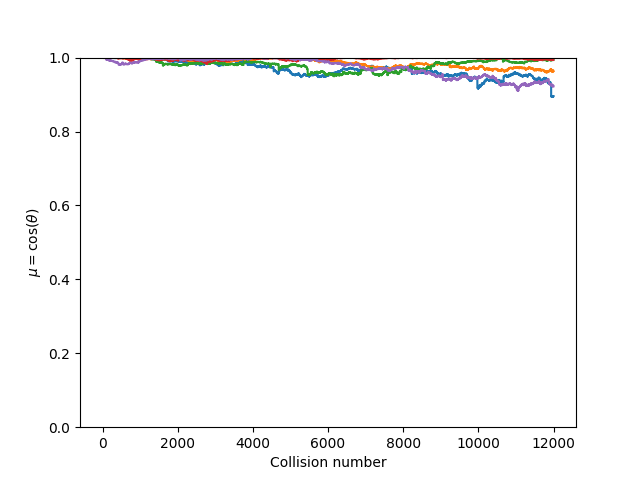

In [20]:
# plot correlation
fig, ax = plt.subplots()
for path in range(paths):
    ax.plot(corr[path, 1:], '-')
ax.set_xlabel('Collision number')
ax.set_ylim([0.0, 1.0])
# ax.set_title('Angle between initial and nth velocity vector.')
ax.set_ylabel('$\mu = \\cos(\\theta)$')
fig.savefig('figures/velocityCorrelation.pdf')

In [8]:
corr

array([1.        , 0.99999289, 0.99995565, ..., 0.98414868, 0.98420648,
       0.98408775])